# DwC Events. PSZMP data

**Puget Sound Zooplankton Monitoring Program dataset.** Alignment of dataset to Darwin Core (DwC) for NANOOS, https://www.nanoos.org. This data alignment work, including this Jupyter notebook, are described in the GitHub repository https://github.com/nanoos-pnw/obis-pszmp. See [README.md](https://github.com/nanoos-pnw/obis-pszmp/blob/main/README.md).   

Emilio Mayorga, https://github.com/emiliom   

4/30-25,9-8,5, 3/25,23,22,19,13,7,5-1. 2/16,15,12,10-9, 1/31/2024

## Goals and scope of this notebook

Parse the source data to define and pull out 3 event "types": `cruise`, `stationVisit` and `sample`. The DwC event table is populated sequentially for each of those event types, in that order, from the most temporally aggregated (cruise) to the most granular (sample). Columns are populated differently depending on the event type. The notebook generates the DwC "event" file `DwC_event.csv`.

## Settings

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPoint

from data_preprocess import create_csv_zip, read_and_parse_sourcedata

In [2]:
data_pth = Path(".")

Set to `True` when debugging. `csv` ﬁles will not be exported when `debug_no_csvexport = True`

In [3]:
debug_no_csvexport = False

## Depth min-max function

From BethElLee:
- **Vertical** tows sample from top to bottom.
    - Max Tow Depth (m) – full water column to within 5 m off bottom up to 200 m (no zeros)
    - Min Tow Depth (m) – 0 m
- **Oblique** tows sample from bottom to top (basically the net gets dropped to the target and then drawn obliquely through the surface water column.
    - Max Tow Depth (m) – 0 m
    - Min Tow Depth (m) – Generally should not be greater than ~30 m

In [4]:
def get_depth_minmax(df, eventtype, min_or_max):
    if eventtype == 'cruise':
        depth_range_cols = ["depth_min_min", "depth_min_max", "depth_max_min", "depth_max_max"]
    else:
        depth_range_cols = ["depth_min", "depth_max"]

    if min_or_max == 'min':
        # Return the minimum value (typically/always 0) even if a NaN is present
        return df[depth_range_cols].min(axis=1, skipna=True)
        # return df[depth_range_cols].min(axis=1, skipna=False)
    else:
        # If any of the depth values is NaN, the max values will be NaN (skipna=False)
        return df[depth_range_cols].max(axis=1, skipna=False)

## Process JSON file containing common mappings and strings

In [5]:
with open(data_pth / 'common_mappings.json') as f:
    mappings = json.load(f)

In [6]:
DatasetCode = mappings['datasetcode']
sampling_groups = mappings['sampling_groups']
net_tow = mappings['net_tow']

iso8601_format = mappings['iso8601_format']
CRS = mappings['CRS']

## Pre-process data for Event table

### Read and pre-processe the source data from Excel file

`usecols` defines the columns that will be kept and the order in which they'll be organized

In [7]:
# Note: I'm including 'Sample Date' and 'Sample Time' just for QA/QC, if needed.
# They won't be used here, since 'time' already captures that information
usecols = [
    'Sample Code', 
    'Station', 'Latitude', 'Longitude', 
    'Site', 'Site Name', 'Basin', 'Sub Basin', 'Region', 
    'Sampling Group',
    'Sample Date', 'Sample Time', 'Day_Night', 'time',
    'Min Tow Depth (m)', 'Max Tow Depth (m)', 'Station Depth (m)',
    'Mesh Size', 'Tow Type', 
]

# eventsource_df = read_and_parse_sourcedata(test_n_rows=10000)[usecols]
eventsource_df = read_and_parse_sourcedata()[usecols]

eventsource_df.rename(
    columns={
        'Sample Code':'sample_code',
        'Station':'station',
        'Latitude':'latitude',
        'Longitude':'longitude',
        'Min Tow Depth (m)':'depth_min', 
        'Max Tow Depth (m)':'depth_max', 
        'Mesh Size': 'mesh_size',
    },
    inplace=True
)

In [8]:
len(eventsource_df)

185737

In [9]:
eventsource_df.head()

,sample_code,station,latitude,longitude,Site,Site Name,Basin,Sub Basin,Region,Sampling Group,Sample Date,Sample Time,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type
0,032514DANAD1147,DANAD,47.17997,-122.8318,DANA,Dana Passage,South Sound,S Puget Sound,Puget Sound,NIT,2014-03-25 00:00:00,11:47:00,D,2014-03-25 11:47:00-07:00,34.0,0.0,39.0,335,Oblique
1,032514DANAD1147,DANAD,47.17997,-122.8318,DANA,Dana Passage,South Sound,S Puget Sound,Puget Sound,NIT,2014-03-25 00:00:00,11:47:00,D,2014-03-25 11:47:00-07:00,34.0,0.0,39.0,335,Oblique
2,032514DANAD1147,DANAD,47.17997,-122.8318,DANA,Dana Passage,South Sound,S Puget Sound,Puget Sound,NIT,2014-03-25 00:00:00,11:47:00,D,2014-03-25 11:47:00-07:00,34.0,0.0,39.0,335,Oblique
3,032514DANAD1147,DANAD,47.17997,-122.8318,DANA,Dana Passage,South Sound,S Puget Sound,Puget Sound,NIT,2014-03-25 00:00:00,11:47:00,D,2014-03-25 11:47:00-07:00,34.0,0.0,39.0,335,Oblique
4,032514DANAD1147,DANAD,47.17997,-122.8318,DANA,Dana Passage,South Sound,S Puget Sound,Puget Sound,NIT,2014-03-25 00:00:00,11:47:00,D,2014-03-25 11:47:00-07:00,34.0,0.0,39.0,335,Oblique


### Remove duplicates

Will return only unique samples, where one row = one sample.

In [10]:
eventsource_df = (
    eventsource_df
    .drop_duplicates()
    .sort_values(by='sample_code')
    .reset_index(drop=True)
)

In [11]:
len(eventsource_df)

3569

### `sample_code` examination

 Sample codes are 14-17 characters long, except for 4 entries that are 12 & 13 characters long.

In [12]:
eventsource_df['sample_code'].str.len().value_counts()

14    1386
17     922
15     860
16     397
12       2
13       2
Name: sample_code, dtype: int64

## Create empty Event dataframe

Records from each event type will be appended to this dataframe, by "type". The type is encoded in the `eventType` column, not in the DwC `type` column, which is not used here explicitly (the type is `Event`).

In [13]:
event_cols_dtypes = np.dtype(
    [
        ('eventID', str),
        ('eventType', str), 
        ('parentEventID', str),
        ('eventDate', str), 
        ('locationID', str),
        ('locality', str),
        ('decimalLatitude', float),
        ('decimalLongitude', float),
        ('geodeticDatum', str),
        ('footprintWKT', str),
        ('footprintSRS', str),
        ('waterBody', str),
        ('countryCode', str), 
        ('stateProvince', str),
        ('minimumDepthInMeters', float),
        ('maximumDepthInMeters', float),
        ('samplingProtocol', str),
        ('eventRemarks', str),
        ('georeferenceRemarks', str),
    ]
)

In [14]:
event_df = pd.DataFrame(np.empty(0, dtype=event_cols_dtypes))

## Create cruise events

Use `Sampling Group` as the grouping attribute, analogous to cruises. Set up a dictionary in `mappings.json` matching up the `Sampling Group` strings to fleshed out descriptions and anything else that might be relevant.

- Assign cruise code based on a date string and a sanitized version of `Sampling Group` strings, from `cruises`
- Use `group_by` to generate cruise `time` start and end
- Come up with cruise `eventID`. Come up with a project/dataset code first
- Populating `event_df` with cruise events

Add cruise-related columns to `eventsource_df`. `date_yyyymmdd` will be used to link cruise events to stationVisit events

In [15]:
eventsource_df['date_yyyymmdd'] = eventsource_df['time'].apply(lambda dt: dt.strftime("%Y%m%d"))
eventsource_df['cruise_code'] = (
    eventsource_df['date_yyyymmdd'] + "_" + eventsource_df['Sampling Group'].apply(lambda s: sampling_groups[s][0])
)

In [16]:
eventsource_df.head()

,sample_code,station,latitude,longitude,Site,Site Name,Basin,Sub Basin,Region,Sampling Group,...,Sample Time,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type,date_yyyymmdd,cruise_code
0,010218ELIV1151,ELIV,48.63795,-122.5694,ELI,Eliza Island,Bellingham Bay,Bellingham Bay,Northern Washington,LUM,...,11:51:00,D,2018-01-02 11:51:00-08:00,0.0,110.0,120.7,200,Vertical,20180102,20180102_LUM
1,010322KSBP01D0815,KSBP01D,47.74396,-122.4282,KSBP01,Point Jefferson,Central Basin,N Central Basin,Puget Sound,KC,...,08:15:00,D,2022-01-03 08:15:00-08:00,22.0,0.0,275.0,335,Oblique,20220103,20220103_KC
2,010422LSNT01D1323,LSNT01D,47.53333,-122.4333,LSNT01,Point Williams,Central Basin,N Central Basin,Puget Sound,KC,...,13:23:00,D,2022-01-04 13:23:00-08:00,22.0,0.0,210.0,335,Oblique,20220104,20220104_KC
3,010422LSNT01V1305,LSNT01V,47.53333,-122.4333,LSNT01,Point Williams,Central Basin,N Central Basin,Puget Sound,KC,...,13:05:00,D,2022-01-04 13:05:00-08:00,0.0,200.0,210.0,200,Vertical,20220104,20220104_KC
4,010422NSEX01V1049,NSEX01V,47.35862,-122.3871,NSEX01,East Passage,Central Basin,S Central Basin,Puget Sound,KC,...,10:49:00,D,2022-01-04 10:49:00-08:00,0.0,170.0,180.0,200,Vertical,20220104,20220104_KC


### Create cruise footprintWKT and centroid points

Will use `MultiPoint` geometry.

In [17]:
cruise_stations_df = eventsource_df[
    ['cruise_code', 'latitude', 'longitude', 'Basin', 'Region', 'Sampling Group']
].drop_duplicates()

In [18]:
len(cruise_stations_df)

3008

In [19]:
cruise_stations_df.head(10)

,cruise_code,latitude,longitude,Basin,Region,Sampling Group
0,20180102_LUM,48.63795,-122.5694,Bellingham Bay,Northern Washington,LUM
1,20220103_KC,47.74396,-122.4282,Central Basin,Puget Sound,KC
2,20220104_KC,47.53333,-122.4333,Central Basin,Puget Sound,KC
4,20220104_KC,47.35862,-122.3871,Central Basin,Puget Sound,KC
5,20210106_NOAA_STIL,48.25673,-122.5442,Whidbey Basin,Puget Sound,NOAA/STIL
6,20180108_NIT,47.15243,-122.6586,South Sound,Puget Sound,NIT
7,20200108_KC,47.74396,-122.4282,Central Basin,Puget Sound,KC
9,20200108_KC,47.53333,-122.4333,Central Basin,Puget Sound,KC
11,20200108_KC,47.35862,-122.3871,Central Basin,Puget Sound,KC
12,20210108_HCSEG_DOE,47.53787,-123.0096,Hood Canal,Puget Sound,HCSEG/DOE


In [20]:
cruise_footprints_df = (
    cruise_stations_df
    .groupby(['cruise_code'])[['longitude', 'latitude']]
    .apply(lambda row: MultiPoint(row.values.tolist()))
    .rename('geometry')
    .reset_index(drop=False)
)
cruise_footprints_gdf = gpd.GeoDataFrame(
    cruise_footprints_df, 
    geometry=cruise_footprints_df['geometry'], 
    crs=CRS
)

In [21]:
len(cruise_footprints_gdf)

1332

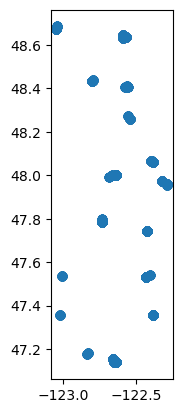

In [22]:
cruise_footprints_gdf.plot();

In [23]:
cruise_footprints_gdf['footprintWKT'] = cruise_footprints_gdf.geometry.to_wkt()

Explode MultiPoints into individual points and retain only the first point for each cruise record. Note: Using MultiPoint centroids often leads to points that fall on land.

In [24]:
firstpoint_gs = cruise_footprints_gdf['geometry'].explode(index_parts=True).groupby(level=0).first()

# No need to merge, because the order is the same.
cruise_footprints_gdf['decimalLongitude'] = firstpoint_gs.x.round(4)
cruise_footprints_gdf['decimalLatitude'] = firstpoint_gs.y.round(4)
# # But the operations add columns 'level_0' and 'index', that need to be removed.
# cruise_footprints_gdf = (
#     cruise_footprints_gdf.drop(columns=['level_0', 'index']).reset_index(drop=False)
# )
cruise_footprints_gdf = cruise_footprints_gdf.reset_index(drop=False)

In [25]:
cruise_footprints_gdf.head()

,index,cruise_code,geometry,footprintWKT,decimalLongitude,decimalLatitude
0,0,20140325_NIT,"MULTIPOINT (-122.83180 47.17997, -122.83520 47...","MULTIPOINT (-122.8318 47.17997, -122.8352 47.1...",-122.8318,47.1800
1,1,20140401_NIT,"MULTIPOINT (-122.63540 47.13843, -122.63770 47...","MULTIPOINT (-122.6354 47.13843, -122.6377 47.1...",-122.6354,47.1384
2,2,20140404_PGST_WDFW,MULTIPOINT (-122.63600 48.00273),MULTIPOINT (-122.636 48.00273),-122.6360,48.0027
3,3,20140409_KC,"MULTIPOINT (-122.43330 47.53333, -122.42820 47...","MULTIPOINT (-122.4333 47.53333, -122.4282 47.7...",-122.4333,47.5333
4,4,20140409_NIT,"MULTIPOINT (-122.63670 47.13892, -122.65860 47...","MULTIPOINT (-122.6367 47.13892, -122.6586 47.1...",-122.6367,47.1389


For the minimum (`x.min`), return a value (typically/always 0) even if a `NaN` is present. For the maximum (`x.max`), return `NaN` if at least one `NaN` is present.


In [26]:
cruise_df = eventsource_df.groupby(['cruise_code', 'date_yyyymmdd', 'Sampling Group']).agg(
    time_min=('time', 'min'),
    time_max=('time', 'max'),
    depth_min_min=('depth_min', lambda x: x.min(skipna=True)),  # instead of simply 'min'
    depth_min_max=('depth_min', lambda x: x.max(skipna=False)),  # instead of simply 'max'
    depth_max_min=('depth_max', lambda x: x.min(skipna=True)),  # instead of simply 'min'
    depth_max_max=('depth_max', lambda x: x.max(skipna=False)),  # instead of simply 'max'
    Basin=('Basin', 'first'),
    Region=('Region', 'first'),
)

cruise_df.head()

,,,time_min,time_max,depth_min_min,depth_min_max,depth_max_min,depth_max_max,Basin,Region
cruise_code,date_yyyymmdd,Sampling Group,,,,,,,,
20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,34.0,0.0,40.0,South Sound,Puget Sound
20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,28.0,0.0,122.0,South Sound,Puget Sound
20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,0.0,100.0,100.0,Admiralty Inlet,Puget Sound
20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,28.0,0.0,200.0,Central Basin,Puget Sound
20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,23.0,0.0,125.0,South Sound,Puget Sound


In [27]:
cruise_df["minimumDepthInMeters"] = get_depth_minmax(cruise_df, 'cruise', 'min')
cruise_df["maximumDepthInMeters"] = get_depth_minmax(cruise_df, 'cruise', 'max')

cruise_df = cruise_df.sort_values(by='cruise_code').reset_index(drop=False)

In [28]:
len(cruise_df.cruise_code.unique()) == len(cruise_df)

True

In [29]:
len(cruise_df), len(cruise_df.cruise_code.unique()), len(cruise_footprints_gdf)

(1332, 1332, 1332)

In [30]:
# This form is for populating eventDate with an iso8601 interval
#     lambda row: "{}/{}".format(row['time_min'].strftime(iso8601_format), 
#                                row['time_max'].strftime(iso8601_format)),

cruise_df['eventDate'] = cruise_df['time_min'].apply(
    lambda t: "{}".format(t.strftime(iso8601_format))
)

In [31]:
cruise_df.head()

,cruise_code,date_yyyymmdd,Sampling Group,time_min,time_max,depth_min_min,depth_min_max,depth_max_min,depth_max_max,Basin,Region,minimumDepthInMeters,maximumDepthInMeters,eventDate
0,20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,34.0,0.0,40.0,South Sound,Puget Sound,0.0,40.0,2014-03-25T10:35:00-0700
1,20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,28.0,0.0,122.0,South Sound,Puget Sound,0.0,122.0,2014-04-01T10:01:00-0700
2,20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,0.0,100.0,100.0,Admiralty Inlet,Puget Sound,0.0,100.0,2014-04-04T13:00:00-0700
3,20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,28.0,0.0,200.0,Central Basin,Puget Sound,0.0,200.0,2014-04-09T09:25:00-0700
4,20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,23.0,0.0,125.0,South Sound,Puget Sound,0.0,125.0,2014-04-09T10:30:00-0700


In [32]:
cruise_df = cruise_df.merge(cruise_footprints_gdf, on='cruise_code')
len(cruise_df)

1332

In [33]:
cruise_df.head()

,cruise_code,date_yyyymmdd,Sampling Group,time_min,time_max,depth_min_min,depth_min_max,depth_max_min,depth_max_max,Basin,Region,minimumDepthInMeters,maximumDepthInMeters,eventDate,index,geometry,footprintWKT,decimalLongitude,decimalLatitude
0,20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,34.0,0.0,40.0,South Sound,Puget Sound,0.0,40.0,2014-03-25T10:35:00-0700,0,"MULTIPOINT (-122.83180 47.17997, -122.83520 47...","MULTIPOINT (-122.8318 47.17997, -122.8352 47.1...",-122.8318,47.1800
1,20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,28.0,0.0,122.0,South Sound,Puget Sound,0.0,122.0,2014-04-01T10:01:00-0700,1,"MULTIPOINT (-122.63540 47.13843, -122.63770 47...","MULTIPOINT (-122.6354 47.13843, -122.6377 47.1...",-122.6354,47.1384
2,20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,0.0,100.0,100.0,Admiralty Inlet,Puget Sound,0.0,100.0,2014-04-04T13:00:00-0700,2,MULTIPOINT (-122.63600 48.00273),MULTIPOINT (-122.636 48.00273),-122.6360,48.0027
3,20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,28.0,0.0,200.0,Central Basin,Puget Sound,0.0,200.0,2014-04-09T09:25:00-0700,3,"MULTIPOINT (-122.43330 47.53333, -122.42820 47...","MULTIPOINT (-122.4333 47.53333, -122.4282 47.7...",-122.4333,47.5333
4,20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,23.0,0.0,125.0,South Sound,Puget Sound,0.0,125.0,2014-04-09T10:30:00-0700,4,"MULTIPOINT (-122.63670 47.13892, -122.65860 47...","MULTIPOINT (-122.6367 47.13892, -122.6586 47.1...",-122.6367,47.1389


### Create additional attributes

Includes global, constant values

In [34]:
cruise_df['eventID'] = DatasetCode + "-CR-" + cruise_df['cruise_code']
cruise_df['waterBody'] = cruise_df['Basin'] + ', ' + cruise_df['Region'] + ', Salish Sea'
cruise_df['eventRemarks'] = "Sample collection by " + cruise_df['Sampling Group'].apply(lambda s: sampling_groups[s][1])
cruise_df['georeferenceRemarks'] = (
    "Monitoring program revisits pre-set stations whose coordinates are reused in each station visit."
    " New GPS readings are not taken."
)

cruise_df['eventType'] = 'cruise'
cruise_df['geodeticDatum'] = CRS
cruise_df['footprintSRS'] = CRS
cruise_df['countryCode'] = 'US'
cruise_df['stateProvince'] = 'Washington'

In [35]:
cruise_df.head()

,cruise_code,date_yyyymmdd,Sampling Group,time_min,time_max,depth_min_min,depth_min_max,depth_max_min,depth_max_max,Basin,...,decimalLatitude,eventID,waterBody,eventRemarks,georeferenceRemarks,eventType,geodeticDatum,footprintSRS,countryCode,stateProvince
0,20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,34.0,0.0,40.0,South Sound,...,47.1800,PSZMP-CR-20140325_NIT,"South Sound, Puget Sound, Salish Sea",Sample collection by Nisqually Indian Tribe,Monitoring program revisits pre-set stations w...,cruise,EPSG:4326,EPSG:4326,US,Washington
1,20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,28.0,0.0,122.0,South Sound,...,47.1384,PSZMP-CR-20140401_NIT,"South Sound, Puget Sound, Salish Sea",Sample collection by Nisqually Indian Tribe,Monitoring program revisits pre-set stations w...,cruise,EPSG:4326,EPSG:4326,US,Washington
2,20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,0.0,100.0,100.0,Admiralty Inlet,...,48.0027,PSZMP-CR-20140404_PGST_WDFW,"Admiralty Inlet, Puget Sound, Salish Sea",Sample collection by Port Gamble S’Klallam Tri...,Monitoring program revisits pre-set stations w...,cruise,EPSG:4326,EPSG:4326,US,Washington
3,20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,28.0,0.0,200.0,Central Basin,...,47.5333,PSZMP-CR-20140409_KC,"Central Basin, Puget Sound, Salish Sea",Sample collection by King County,Monitoring program revisits pre-set stations w...,cruise,EPSG:4326,EPSG:4326,US,Washington
4,20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,23.0,0.0,125.0,South Sound,...,47.1389,PSZMP-CR-20140409_NIT,"South Sound, Puget Sound, Salish Sea",Sample collection by Nisqually Indian Tribe,Monitoring program revisits pre-set stations w...,cruise,EPSG:4326,EPSG:4326,US,Washington


### Populate (append to) the `event_df` table with the cruise events

In [36]:
event_df = pd.concat(
    [
        event_df,
        cruise_df[[
            'eventID', 'eventType', 'eventDate', 
            'decimalLatitude', 'decimalLongitude', 'geodeticDatum',
            'footprintWKT', 'footprintSRS', 
            'waterBody', 'countryCode', 'stateProvince',
            'minimumDepthInMeters', 'maximumDepthInMeters',
            'eventRemarks', 'georeferenceRemarks'
        ]]
    ],
    ignore_index=True
)

In [37]:
event_df.head()

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,geodeticDatum,footprintWKT,footprintSRS,waterBody,countryCode,stateProvince,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,eventRemarks,georeferenceRemarks
0,PSZMP-CR-20140325_NIT,cruise,NaN,2014-03-25T10:35:00-0700,NaN,NaN,47.1800,-122.8318,EPSG:4326,"MULTIPOINT (-122.8318 47.17997, -122.8352 47.1...",EPSG:4326,"South Sound, Puget Sound, Salish Sea",US,Washington,0.0,40.0,NaN,Sample collection by Nisqually Indian Tribe,Monitoring program revisits pre-set stations w...
1,PSZMP-CR-20140401_NIT,cruise,NaN,2014-04-01T10:01:00-0700,NaN,NaN,47.1384,-122.6354,EPSG:4326,"MULTIPOINT (-122.6354 47.13843, -122.6377 47.1...",EPSG:4326,"South Sound, Puget Sound, Salish Sea",US,Washington,0.0,122.0,NaN,Sample collection by Nisqually Indian Tribe,Monitoring program revisits pre-set stations w...
2,PSZMP-CR-20140404_PGST_WDFW,cruise,NaN,2014-04-04T13:00:00-0700,NaN,NaN,48.0027,-122.6360,EPSG:4326,MULTIPOINT (-122.636 48.00273),EPSG:4326,"Admiralty Inlet, Puget Sound, Salish Sea",US,Washington,0.0,100.0,NaN,Sample collection by Port Gamble S’Klallam Tri...,Monitoring program revisits pre-set stations w...
3,PSZMP-CR-20140409_KC,cruise,NaN,2014-04-09T09:25:00-0700,NaN,NaN,47.5333,-122.4333,EPSG:4326,"MULTIPOINT (-122.4333 47.53333, -122.4282 47.7...",EPSG:4326,"Central Basin, Puget Sound, Salish Sea",US,Washington,0.0,200.0,NaN,Sample collection by King County,Monitoring program revisits pre-set stations w...
4,PSZMP-CR-20140409_NIT,cruise,NaN,2014-04-09T10:30:00-0700,NaN,NaN,47.1389,-122.6367,EPSG:4326,"MULTIPOINT (-122.6367 47.13892, -122.6586 47.1...",EPSG:4326,"South Sound, Puget Sound, Salish Sea",US,Washington,0.0,125.0,NaN,Sample collection by Nisqually Indian Tribe,Monitoring program revisits pre-set stations w...


## Create stationVisit events

- Each unique `sample_code` will be a `stationVisit` event. Relationship between `stationVisit` and `sample` events is 1:1
- Use cruise `eventID` from `eventsource_df` as stationVisit `parentEventID`
- Add `stationvisit_code` to `eventsource_df`, for use by the next event type (sample)

In [38]:
# eventsource_df['Sample Code'].str[0:-4].head(10)

`stationvisit_code` will be composed of the date (`date_yyyymmdd`), `Day_Night` and `station`. Assumes a station is not visited (sampled) twice on the same day within the same diurnal period (Day vs Night).

In [39]:
eventsource_df['stationvisit_code'] = (
    # eventsource_df['sample_code'].str[0:-4] + eventsource_df['Day_Night']
    eventsource_df['date_yyyymmdd'] + eventsource_df['Day_Night'] + "_" + eventsource_df['station']
)

In [40]:
stationvisit_df = eventsource_df.copy()
stationvisit_df.head()

,sample_code,station,latitude,longitude,Site,Site Name,Basin,Sub Basin,Region,Sampling Group,...,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type,date_yyyymmdd,cruise_code,stationvisit_code
0,010218ELIV1151,ELIV,48.63795,-122.5694,ELI,Eliza Island,Bellingham Bay,Bellingham Bay,Northern Washington,LUM,...,D,2018-01-02 11:51:00-08:00,0.0,110.0,120.7,200,Vertical,20180102,20180102_LUM,20180102D_ELIV
1,010322KSBP01D0815,KSBP01D,47.74396,-122.4282,KSBP01,Point Jefferson,Central Basin,N Central Basin,Puget Sound,KC,...,D,2022-01-03 08:15:00-08:00,22.0,0.0,275.0,335,Oblique,20220103,20220103_KC,20220103D_KSBP01D
2,010422LSNT01D1323,LSNT01D,47.53333,-122.4333,LSNT01,Point Williams,Central Basin,N Central Basin,Puget Sound,KC,...,D,2022-01-04 13:23:00-08:00,22.0,0.0,210.0,335,Oblique,20220104,20220104_KC,20220104D_LSNT01D
3,010422LSNT01V1305,LSNT01V,47.53333,-122.4333,LSNT01,Point Williams,Central Basin,N Central Basin,Puget Sound,KC,...,D,2022-01-04 13:05:00-08:00,0.0,200.0,210.0,200,Vertical,20220104,20220104_KC,20220104D_LSNT01V
4,010422NSEX01V1049,NSEX01V,47.35862,-122.3871,NSEX01,East Passage,Central Basin,S Central Basin,Puget Sound,KC,...,D,2022-01-04 10:49:00-08:00,0.0,170.0,180.0,200,Vertical,20220104,20220104_KC,20220104D_NSEX01V


In [41]:
stationvisit_df = stationvisit_df[
    ['date_yyyymmdd', 'Sampling Group', 'stationvisit_code', 
     'station', 'latitude', 'longitude', 'Site', 'Site Name', 'Basin', 'Sub Basin', 'Region',
     'Day_Night', 'time', 'depth_min', 'depth_max']
].merge(
    # cruise_df[['date_yyyymmdd', 'eventID', 'waterBody', 'countryCode']],
    cruise_df[
        ['date_yyyymmdd', 'Sampling Group', 'eventID', 'geodeticDatum',
         'countryCode', 'stateProvince', 'eventRemarks', 'georeferenceRemarks']
    ],
    how='left', 
    on=['date_yyyymmdd', 'Sampling Group']
)

In [42]:
stationvisit_df["minimumDepthInMeters"] = get_depth_minmax(stationvisit_df, 'stationVisit', 'min')
stationvisit_df["maximumDepthInMeters"] = get_depth_minmax(stationvisit_df, 'stationVisit', 'max')

stationvisit_df = stationvisit_df.sort_values(by='time').reset_index(drop=False)

In [43]:
len(stationvisit_df)

3569

In [44]:
stationvisit_df.head()

,index,date_yyyymmdd,Sampling Group,stationvisit_code,station,latitude,longitude,Site,Site Name,Basin,...,depth_min,depth_max,eventID,geodeticDatum,countryCode,stateProvince,eventRemarks,georeferenceRemarks,minimumDepthInMeters,maximumDepthInMeters
0,523,20140325,NIT,20140325D_DANAV,DANAV,47.18327,-122.8307,DANA,Dana Passage,South Sound,...,0.0,40.0,PSZMP-CR-20140325_NIT,EPSG:4326,US,Washington,Sample collection by Nisqually Indian Tribe,Monitoring program revisits pre-set stations w...,0.0,40.0
1,522,20140325,NIT,20140325D_DANAS,DANAS,47.17593,-122.8355,DANA,Dana Passage,South Sound,...,34.0,0.0,PSZMP-CR-20140325_NIT,EPSG:4326,US,Washington,Sample collection by Nisqually Indian Tribe,Monitoring program revisits pre-set stations w...,0.0,34.0
2,521,20140325,NIT,20140325D_DANAM,DANAM,47.17678,-122.8352,DANA,Dana Passage,South Sound,...,34.0,0.0,PSZMP-CR-20140325_NIT,EPSG:4326,US,Washington,Sample collection by Nisqually Indian Tribe,Monitoring program revisits pre-set stations w...,0.0,34.0
3,520,20140325,NIT,20140325D_DANAD,DANAD,47.17997,-122.8318,DANA,Dana Passage,South Sound,...,34.0,0.0,PSZMP-CR-20140325_NIT,EPSG:4326,US,Washington,Sample collection by Nisqually Indian Tribe,Monitoring program revisits pre-set stations w...,0.0,34.0
4,578,20140401,NIT,20140401D_SKETV,SKETV,47.15243,-122.6586,SKET,South Ketron/Solo Point,South Sound,...,0.0,122.0,PSZMP-CR-20140401_NIT,EPSG:4326,US,Washington,Sample collection by Nisqually Indian Tribe,Monitoring program revisits pre-set stations w...,0.0,122.0


In [45]:
stationvisit_df.rename(
    columns={
        'station':'locationID',
        'latitude':'decimalLatitude',
        'longitude':'decimalLongitude',
        'eventID':'parentEventID',
    },
    inplace=True
)

In [46]:
stationvisit_df['eventDate'] = stationvisit_df['time'].apply(
    lambda t: "{}".format(t.strftime(iso8601_format))
)

In [47]:
stationvisit_df['eventID'] = DatasetCode + "-STA-" + stationvisit_df['stationvisit_code']
stationvisit_df['waterBody'] = stationvisit_df['Basin'] + ', ' + stationvisit_df['Region'] + ', Salish Sea'
stationvisit_df['locality'] = (
    stationvisit_df['Site Name'] + ' (' + stationvisit_df['Site'] + '), ' + stationvisit_df['Sub Basin']
)

stationvisit_df['eventType'] = 'stationVisit'

Verify that no duplicate station `eventID` values are created. The `==` statement below should be `True`

In [48]:
len(stationvisit_df.eventID.unique()) == len(stationvisit_df), len(stationvisit_df)

(True, 3569)

In [49]:
stationvisit_df.tail(5)

,index,date_yyyymmdd,Sampling Group,stationvisit_code,locationID,decimalLatitude,decimalLongitude,Site,Site Name,Basin,...,stateProvince,eventRemarks,georeferenceRemarks,minimumDepthInMeters,maximumDepthInMeters,eventDate,eventID,waterBody,locality,eventType
3564,3534,20221214,HCSEG/DOE,20221214D_HCB003V,HCB003V,47.53787,-123.0096,HCB,Eldon,Hood Canal,...,Washington,Sample collection by Hood Canal Salmon Enhance...,Monitoring program revisits pre-set stations w...,0.0,139.0,2022-12-14T10:29:00-0800,PSZMP-STA-20221214D_HCB003V,"Hood Canal, Puget Sound, Salish Sea","Eldon (HCB), S Hood Canal",stationVisit
3565,3535,20221214,HCSEG/DOE,20221214D_HCB004V,HCB004V,47.35620,-123.0249,HCB,Sisters Point,Hood Canal,...,Washington,Sample collection by Hood Canal Salmon Enhance...,Monitoring program revisits pre-set stations w...,0.0,48.0,2022-12-14T11:37:00-0800,PSZMP-STA-20221214D_HCB004V,"Hood Canal, Puget Sound, Salish Sea","Sisters Point (HCB), S Hood Canal",stationVisit
3566,3540,20221215,NOAA/STIL,20221215D_SARAV,SARAV,48.25673,-122.5442,SARA,North Saratoga Passage,Whidbey Basin,...,Washington,Sample collection by NOAA Northwest Fisheries ...,Monitoring program revisits pre-set stations w...,0.0,85.0,2022-12-15T11:37:00-0800,PSZMP-STA-20221215D_SARAV,"Whidbey Basin, Puget Sound, Salish Sea","North Saratoga Passage (SARA), N Whidbey Basin",stationVisit
3567,3558,20221219,PGST/WDFW,20221219D_ADIV,ADIV,48.00273,-122.6360,ADI,Admiralty Inlet,Admiralty Inlet,...,Washington,Sample collection by Port Gamble S’Klallam Tri...,Monitoring program revisits pre-set stations w...,0.0,120.0,2022-12-19T10:27:00-0800,PSZMP-STA-20221219D_ADIV,"Admiralty Inlet, Puget Sound, Salish Sea","Admiralty Inlet (ADI), Admiralty Inlet",stationVisit
3568,3559,20221219,PGST/WDFW,20221219D_TDBV,TDBV,47.78297,-122.7330,TDB,Thorndyke Bay,Hood Canal,...,Washington,Sample collection by Port Gamble S’Klallam Tri...,Monitoring program revisits pre-set stations w...,0.0,115.0,2022-12-19T11:58:00-0800,PSZMP-STA-20221219D_TDBV,"Hood Canal, Puget Sound, Salish Sea","Thorndyke Bay (TDB), N Hood Canal",stationVisit


### Populate (append to) the `event_df` table with the stationVisit events

In [50]:
event_df = pd.concat(
    [
        event_df,
        stationvisit_df[[
            'eventID', 'eventType', 'parentEventID', 'eventDate', 
            'locationID', 'locality', 
            'decimalLatitude', 'decimalLongitude', 'geodeticDatum',
            'waterBody', 'countryCode', 'stateProvince',
            'minimumDepthInMeters', 'maximumDepthInMeters',
            'eventRemarks', 'georeferenceRemarks'
        ]]
    ],
    ignore_index=True
)

len(event_df)

4901

In [51]:
event_df.tail(10)

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,geodeticDatum,footprintWKT,footprintSRS,waterBody,countryCode,stateProvince,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,eventRemarks,georeferenceRemarks
4891,PSZMP-STA-20221206D_NSEX01V,stationVisit,PSZMP-CR-20221206_KC,2022-12-06T12:36:00-0800,NSEX01V,"East Passage (NSEX01), S Central Basin",47.35862,-122.3871,EPSG:4326,NaN,NaN,"Central Basin, Puget Sound, Salish Sea",US,Washington,0.0,170.0,NaN,Sample collection by King County,Monitoring program revisits pre-set stations w...
4892,PSZMP-STA-20221212D_COW3V2,stationVisit,PSZMP-CR-20221212_KWT,2022-12-12T11:27:00-0800,COW3V2,"Cowlitz (COW), San Juan",48.67437,-123.0481,EPSG:4326,NaN,NaN,"San Juan, Northern Washington, Salish Sea",US,Washington,0.0,70.0,NaN,Sample collection by Kwiáht,Monitoring program revisits pre-set stations w...
4893,PSZMP-STA-20221212D_MUKV,stationVisit,PSZMP-CR-20221212_TUL,2022-12-12T11:42:00-0800,MUKV,"Mukilteo (MUK), S Whidbey Basin",47.97166,-122.3222,EPSG:4326,NaN,NaN,"Whidbey Basin, Puget Sound, Salish Sea",US,Washington,0.0,200.0,NaN,Sample collection by Tulalip Tribe,Monitoring program revisits pre-set stations w...
4894,PSZMP-STA-20221212D_CAMV,stationVisit,PSZMP-CR-20221212_TUL,2022-12-12T12:31:00-0800,CAMV,"Camano Head (CAM), S Whidbey Basin",48.05901,-122.3873,EPSG:4326,NaN,NaN,"Whidbey Basin, Puget Sound, Salish Sea",US,Washington,0.0,175.0,NaN,Sample collection by Tulalip Tribe,Monitoring program revisits pre-set stations w...
4895,PSZMP-STA-20221212D_WAT1V,stationVisit,PSZMP-CR-20221212_KWT,2022-12-12T13:44:00-0800,WAT1V,"Watmough Bay (WAT), San Juan",48.43457,-122.8037,EPSG:4326,NaN,NaN,"San Juan, Northern Washington, Salish Sea",US,Washington,0.0,30.0,NaN,Sample collection by Kwiáht,Monitoring program revisits pre-set stations w...
4896,PSZMP-STA-20221214D_HCB003V,stationVisit,PSZMP-CR-20221214_HCSEG_DOE,2022-12-14T10:29:00-0800,HCB003V,"Eldon (HCB), S Hood Canal",47.53787,-123.0096,EPSG:4326,NaN,NaN,"Hood Canal, Puget Sound, Salish Sea",US,Washington,0.0,139.0,NaN,Sample collection by Hood Canal Salmon Enhance...,Monitoring program revisits pre-set stations w...
4897,PSZMP-STA-20221214D_HCB004V,stationVisit,PSZMP-CR-20221214_HCSEG_DOE,2022-12-14T11:37:00-0800,HCB004V,"Sisters Point (HCB), S Hood Canal",47.35620,-123.0249,EPSG:4326,NaN,NaN,"Hood Canal, Puget Sound, Salish Sea",US,Washington,0.0,48.0,NaN,Sample collection by Hood Canal Salmon Enhance...,Monitoring program revisits pre-set stations w...
4898,PSZMP-STA-20221215D_SARAV,stationVisit,PSZMP-CR-20221215_NOAA_STIL,2022-12-15T11:37:00-0800,SARAV,"North Saratoga Passage (SARA), N Whidbey Basin",48.25673,-122.5442,EPSG:4326,NaN,NaN,"Whidbey Basin, Puget Sound, Salish Sea",US,Washington,0.0,85.0,NaN,Sample collection by NOAA Northwest Fisheries ...,Monitoring program revisits pre-set stations w...
4899,PSZMP-STA-20221219D_ADIV,stationVisit,PSZMP-CR-20221219_PGST_WDFW,2022-12-19T10:27:00-0800,ADIV,"Admiralty Inlet (ADI), Admiralty Inlet",48.00273,-122.6360,EPSG:4326,NaN,NaN,"Admiralty Inlet, Puget Sound, Salish Sea",US,Washington,0.0,120.0,NaN,Sample collection by Port Gamble S’Klallam Tri...,Monitoring program revisits pre-set stations w...
4900,PSZMP-STA-20221219D_TDBV,stationVisit,PSZMP-CR-20221219_PGST_WDFW,2022-12-19T11:58:00-0800,TDBV,"Thorndyke Bay (TDB), N Hood Canal",47.78297,-122.7330,EPSG:4326,NaN,NaN,"Hood Canal, Puget Sound, Salish Sea",US,Washington,0.0,115.0,NaN,Sample collection by Port Gamble S’Klallam Tri...,Monitoring program revisits pre-set stations w...


## Create individual "sample" events

Each unique `sample_code` will be an event. `sample_code` will be the eventID, possibly prefixed by the dataset code.

In [52]:
sample_df = eventsource_df.copy()
sample_df.head()

,sample_code,station,latitude,longitude,Site,Site Name,Basin,Sub Basin,Region,Sampling Group,...,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type,date_yyyymmdd,cruise_code,stationvisit_code
0,010218ELIV1151,ELIV,48.63795,-122.5694,ELI,Eliza Island,Bellingham Bay,Bellingham Bay,Northern Washington,LUM,...,D,2018-01-02 11:51:00-08:00,0.0,110.0,120.7,200,Vertical,20180102,20180102_LUM,20180102D_ELIV
1,010322KSBP01D0815,KSBP01D,47.74396,-122.4282,KSBP01,Point Jefferson,Central Basin,N Central Basin,Puget Sound,KC,...,D,2022-01-03 08:15:00-08:00,22.0,0.0,275.0,335,Oblique,20220103,20220103_KC,20220103D_KSBP01D
2,010422LSNT01D1323,LSNT01D,47.53333,-122.4333,LSNT01,Point Williams,Central Basin,N Central Basin,Puget Sound,KC,...,D,2022-01-04 13:23:00-08:00,22.0,0.0,210.0,335,Oblique,20220104,20220104_KC,20220104D_LSNT01D
3,010422LSNT01V1305,LSNT01V,47.53333,-122.4333,LSNT01,Point Williams,Central Basin,N Central Basin,Puget Sound,KC,...,D,2022-01-04 13:05:00-08:00,0.0,200.0,210.0,200,Vertical,20220104,20220104_KC,20220104D_LSNT01V
4,010422NSEX01V1049,NSEX01V,47.35862,-122.3871,NSEX01,East Passage,Central Basin,S Central Basin,Puget Sound,KC,...,D,2022-01-04 10:49:00-08:00,0.0,170.0,180.0,200,Vertical,20220104,20220104_KC,20220104D_NSEX01V


In [53]:
sample_df = sample_df.merge(
    stationvisit_df[['stationvisit_code', 'eventID',
                     'locationID', 'locality', 'geodeticDatum',
                     'waterBody', 'countryCode', 'stateProvince',
                     'eventRemarks', 'georeferenceRemarks']],
    how='left', 
    on='stationvisit_code'
)

In [54]:
sample_df["minimumDepthInMeters"] = get_depth_minmax(sample_df, 'sample', 'min')
sample_df["maximumDepthInMeters"] = get_depth_minmax(sample_df, 'sample', 'max')

In [55]:
sample_df= (
    sample_df
    .rename(columns={
        'eventID':'parentEventID',
        'latitude':'decimalLatitude',
        'longitude':'decimalLongitude',
    })
    .sort_values(by='time')
    .reset_index(drop=False)
)

In [56]:
# two nets: 
# - a 60cm diameter ring net with 200um mesh towed vertically (Vertical)
# - a 60cm bongo net with 335um mesh towed obliquely through the top 30m of the water column (Oblique)
net_type = dict(Vertical="ring", Oblique="bongo")
def samplingProtocol(row):
    return (
        f"{net_tow[row['Tow Type']]} net tow using 60cm diameter"
        f" {net_type[row['Tow Type']]} net,"
        f" {row['mesh_size']} micron mesh"
    )

sample_df['eventID'] = DatasetCode + "-SMP-" + sample_df['sample_code']
sample_df['eventDate'] = sample_df['time'].apply(lambda t: t.strftime(iso8601_format))
sample_df['samplingProtocol'] = sample_df.apply(samplingProtocol, axis=1)

sample_df['eventRemarks'] = (
    sample_df['eventRemarks'] + ". Original sample code: " + sample_df['sample_code']
)

sample_df['eventType'] = 'sample'

In [57]:
sample_df.head()

,index,sample_code,station,decimalLatitude,decimalLongitude,Site,Site Name,Basin,Sub Basin,Region,...,countryCode,stateProvince,eventRemarks,georeferenceRemarks,minimumDepthInMeters,maximumDepthInMeters,eventID,eventDate,samplingProtocol,eventType
0,523,032514DANAV1035,DANAV,47.18327,-122.8307,DANA,Dana Passage,South Sound,S Puget Sound,Puget Sound,...,US,Washington,Sample collection by Nisqually Indian Tribe. O...,Monitoring program revisits pre-set stations w...,0.0,40.0,PSZMP-SMP-032514DANAV1035,2014-03-25T10:35:00-0700,full water column vertical net tow using 60cm ...,sample
1,522,032514DANAS1108,DANAS,47.17593,-122.8355,DANA,Dana Passage,South Sound,S Puget Sound,Puget Sound,...,US,Washington,Sample collection by Nisqually Indian Tribe. O...,Monitoring program revisits pre-set stations w...,0.0,34.0,PSZMP-SMP-032514DANAS1108,2014-03-25T11:08:00-0700,"oblique net tow using 60cm diameter bongo net,...",sample
2,521,032514DANAM1126,DANAM,47.17678,-122.8352,DANA,Dana Passage,South Sound,S Puget Sound,Puget Sound,...,US,Washington,Sample collection by Nisqually Indian Tribe. O...,Monitoring program revisits pre-set stations w...,0.0,34.0,PSZMP-SMP-032514DANAM1126,2014-03-25T11:26:00-0700,"oblique net tow using 60cm diameter bongo net,...",sample
3,520,032514DANAD1147,DANAD,47.17997,-122.8318,DANA,Dana Passage,South Sound,S Puget Sound,Puget Sound,...,US,Washington,Sample collection by Nisqually Indian Tribe. O...,Monitoring program revisits pre-set stations w...,0.0,34.0,PSZMP-SMP-032514DANAD1147,2014-03-25T11:47:00-0700,"oblique net tow using 60cm diameter bongo net,...",sample
4,578,040114sketv1001,SKETV,47.15243,-122.6586,SKET,South Ketron/Solo Point,South Sound,South Sound,Puget Sound,...,US,Washington,Sample collection by Nisqually Indian Tribe. O...,Monitoring program revisits pre-set stations w...,0.0,122.0,PSZMP-SMP-040114sketv1001,2014-04-01T10:01:00-0700,full water column vertical net tow using 60cm ...,sample


Verify that no duplicate sample `eventID` values are created. The `==` statement below should be `True`

In [58]:
len(sample_df.eventID.unique()) == len(sample_df), len(sample_df)

(True, 3569)

### Populate (append to) the `event_df` table with the sample events

In [59]:
event_df = pd.concat(
    [
        event_df,
        sample_df[[
            'eventID', 'eventType', 'parentEventID', 'eventDate', 
            'locationID', 'locality', 
            'decimalLatitude', 'decimalLongitude', 'geodeticDatum',
            'waterBody', 'countryCode', 'stateProvince',
            'minimumDepthInMeters', 'maximumDepthInMeters', 'samplingProtocol',
            'eventRemarks', 'georeferenceRemarks'
        ]]
    ],
    ignore_index=True
)

len(event_df)

8470

In [60]:
event_df.tail(10)

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,geodeticDatum,footprintWKT,footprintSRS,waterBody,countryCode,stateProvince,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,eventRemarks,georeferenceRemarks
8460,PSZMP-SMP-120622NSEX01V1236,sample,PSZMP-STA-20221206D_NSEX01V,2022-12-06T12:36:00-0800,NSEX01V,"East Passage (NSEX01), S Central Basin",47.35862,-122.3871,EPSG:4326,NaN,NaN,"Central Basin, Puget Sound, Salish Sea",US,Washington,0.0,170.0,full water column vertical net tow using 60cm ...,Sample collection by King County. Original sam...,Monitoring program revisits pre-set stations w...
8461,PSZMP-SMP-121222Cow3V21127,sample,PSZMP-STA-20221212D_COW3V2,2022-12-12T11:27:00-0800,COW3V2,"Cowlitz (COW), San Juan",48.67437,-123.0481,EPSG:4326,NaN,NaN,"San Juan, Northern Washington, Salish Sea",US,Washington,0.0,70.0,full water column vertical net tow using 60cm ...,Sample collection by Kwiáht. Original sample c...,Monitoring program revisits pre-set stations w...
8462,PSZMP-SMP-121222MUKV1142,sample,PSZMP-STA-20221212D_MUKV,2022-12-12T11:42:00-0800,MUKV,"Mukilteo (MUK), S Whidbey Basin",47.97166,-122.3222,EPSG:4326,NaN,NaN,"Whidbey Basin, Puget Sound, Salish Sea",US,Washington,0.0,200.0,full water column vertical net tow using 60cm ...,Sample collection by Tulalip Tribe. Original s...,Monitoring program revisits pre-set stations w...
8463,PSZMP-SMP-121222CAMV1231,sample,PSZMP-STA-20221212D_CAMV,2022-12-12T12:31:00-0800,CAMV,"Camano Head (CAM), S Whidbey Basin",48.05901,-122.3873,EPSG:4326,NaN,NaN,"Whidbey Basin, Puget Sound, Salish Sea",US,Washington,0.0,175.0,full water column vertical net tow using 60cm ...,Sample collection by Tulalip Tribe. Original s...,Monitoring program revisits pre-set stations w...
8464,PSZMP-SMP-121222Wat1V1344,sample,PSZMP-STA-20221212D_WAT1V,2022-12-12T13:44:00-0800,WAT1V,"Watmough Bay (WAT), San Juan",48.43457,-122.8037,EPSG:4326,NaN,NaN,"San Juan, Northern Washington, Salish Sea",US,Washington,0.0,30.0,full water column vertical net tow using 60cm ...,Sample collection by Kwiáht. Original sample c...,Monitoring program revisits pre-set stations w...
8465,PSZMP-SMP-121422HCB003V1029,sample,PSZMP-STA-20221214D_HCB003V,2022-12-14T10:29:00-0800,HCB003V,"Eldon (HCB), S Hood Canal",47.53787,-123.0096,EPSG:4326,NaN,NaN,"Hood Canal, Puget Sound, Salish Sea",US,Washington,0.0,139.0,full water column vertical net tow using 60cm ...,Sample collection by Hood Canal Salmon Enhance...,Monitoring program revisits pre-set stations w...
8466,PSZMP-SMP-121422HCB004V1137,sample,PSZMP-STA-20221214D_HCB004V,2022-12-14T11:37:00-0800,HCB004V,"Sisters Point (HCB), S Hood Canal",47.35620,-123.0249,EPSG:4326,NaN,NaN,"Hood Canal, Puget Sound, Salish Sea",US,Washington,0.0,48.0,full water column vertical net tow using 60cm ...,Sample collection by Hood Canal Salmon Enhance...,Monitoring program revisits pre-set stations w...
8467,PSZMP-SMP-121522SARAV1137,sample,PSZMP-STA-20221215D_SARAV,2022-12-15T11:37:00-0800,SARAV,"North Saratoga Passage (SARA), N Whidbey Basin",48.25673,-122.5442,EPSG:4326,NaN,NaN,"Whidbey Basin, Puget Sound, Salish Sea",US,Washington,0.0,85.0,full water column vertical net tow using 60cm ...,Sample collection by NOAA Northwest Fisheries ...,Monitoring program revisits pre-set stations w...
8468,PSZMP-SMP-121922ADIV1027,sample,PSZMP-STA-20221219D_ADIV,2022-12-19T10:27:00-0800,ADIV,"Admiralty Inlet (ADI), Admiralty Inlet",48.00273,-122.6360,EPSG:4326,NaN,NaN,"Admiralty Inlet, Puget Sound, Salish Sea",US,Washington,0.0,120.0,full water column vertical net tow using 60cm ...,Sample collection by Port Gamble S’Klallam Tri...,Monitoring program revisits pre-set stations w...
8469,PSZMP-SMP-121922TDBV1158,sample,PSZMP-STA-20221219D_TDBV,2022-12-19T11:58:00-0800,TDBV,"Thorndyke Bay (TDB), N Hood Canal",47.78297,-122.7330,EPSG:4326,NaN,NaN,"Hood Canal, Puget Sound, Salish Sea",US,Washington,0.0,115.0,full water column vertical net tow using 60cm ...,Sam

## Export `event_df` to csv

In [61]:
event_df.eventType.value_counts()

stationVisit    3569
sample          3569
cruise          1332
Name: eventType, dtype: int64

In [62]:
csv_fpth = data_pth / "aligned_csvs" / "DwC_event.csv"

In [63]:
if not debug_no_csvexport:
    event_df.to_csv(csv_fpth, index=False)

### Create zip file with the csv

In [64]:
if not debug_no_csvexport:
    create_csv_zip(csv_fpth)

## Package versions

In [65]:
import datetime

print(
    f"{datetime.datetime.utcnow()} +00:00\n"
    f"pandas: {pd.__version__}, geopandas: {gpd.__version__}"
)

2024-04-30 22:37:02.146078 +00:00
pandas: 1.5.3, geopandas: 0.12.2
